# To check which GPU is available 


In [1]:
!nvidia-smi

Fri May 14 17:29:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.73.01    Driver Version: 460.73.01    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3090    Off  | 00000000:3B:00.0 Off |                  N/A |
| 53%   35C    P8    32W / 350W |  23749MiB / 24267MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 3090    Off  | 00000000:AF:00.0 Off |                  N/A |
| 53%   

# Importing Packages




In [1]:

import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np 
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

from model_file import unet
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical

In [ ]:
# Initializing model 
model =unet(input_height=512, input_width=800,classes=2)

In [12]:
#Checking Model configuration
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 512, 800, 3) 0                                            
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 512, 800, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_14 (BatchNo (None, 512, 800, 64) 256         conv2d_34[0][0]                  
__________________________________________________________________________________________________
conv2d_35 (Conv2D)              (None, 512, 800, 64) 36928       batch_normalization_14[0][0]     
____________________________________________________________________________________________

# Reading the images
There are efficient ways to load and train the model, this method is expensive to use given that you are reading all the samples at the same time.

In [18]:
import glob
import re
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import numpy as np

def sorted_nicely( li ):
    convert = lambda text: int(text) if text.isdigit() else text
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)', key)]
    return sorted(li, key = alphanum_key)
    
orig_list = glob.glob('/home/sami/Crop Pro/Broad_leaf/Broadleaf 2021_04_19/Field_Wise_Data/Starco Rob Millar Sand Pile Lentils/Field/*.jpg')
orig_list = sorted_nicely(orig_list)
anot_list = glob.glob('/home/sami/Crop Pro/Broad_leaf/Broadleaf 2021_04_19/Field_Wise_Data/Starco Rob Millar Sand Pile Lentils/Map/*.png')


anot_list = sorted_nicely(anot_list)
orig_train, orig_test, anot_train, anot_test = train_test_split(orig_list,anot_list,test_size = 0.1)

x_train = np.asarray(orig_train)
y_train = np.asarray(anot_train)
x_val   = np.asarray(orig_test)
y_val   = np.asarray(anot_test)

Y_train = np.array([image.img_to_array(image.load_img(fname,color_mode = "grayscale"),dtype="uint8") for fname in y_train[:100]])
X_train = np.array([image.img_to_array(image.load_img(fname)) for fname in x_train]) #
Y_val = np.array([image.img_to_array(image.load_img(fname,color_mode = "grayscale"),dtype="uint8") for fname in y_val[:10]])
X_val = np.array([image.img_to_array(image.load_img(fname)) for fname in x_val])


In [4]:
# To see how many classes are there
np.unique(Y_val)

array([0, 1], dtype=uint8)

In [12]:
#Converting to catagorical data 
Y_train = to_categorical(Y_train, num_classes=2, dtype='float32')
Y_val = to_categorical(Y_val, num_classes=2, dtype='float32')

In [15]:
#Defining Loss function 
import tensorflow as tf
def dice_loss(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=-1)
    denominator = tf.reduce_sum(y_true + y_pred, axis=-1)

    return 1 - (numerator + 1) / (denominator + 1)

In [ ]:
#optimizer and compiling the model
from keras.optimizers import Adam
opt = Adam(lr=0.0001, beta_1=0.5)
model.compile(loss=dice_loss, optimizer=opt, metrics=["accuracy"])

In [36]:
# Transfer Learning
model.load_weights('./unet_simple_fine.h5')

In [37]:
#Training and using callback
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint('unet_simple_fine.h5', verbose=1, save_best_only=True, save_weights_only=True)
]

history = model.fit(X_train,Y_train, batch_size=5, epochs=20,callbacks=callbacks,validation_data=(X_val,Y_val))

Epoch 1/20
20/20 [==============================] - 23s 588ms/step - loss: 0.0491 - accuracy: 0.9279 - val_loss: 0.0436 - val_accuracy: 0.9373

Epoch 00001: val_loss improved from inf to 0.04361, saving model to unet_simple_fine.h5
Epoch 2/20
20/20 [==============================] - 11s 562ms/step - loss: 0.0513 - accuracy: 0.9244 - val_loss: 0.0404 - val_accuracy: 0.9419

Epoch 00002: val_loss improved from 0.04361 to 0.04040, saving model to unet_simple_fine.h5
Epoch 3/20
20/20 [==============================] - 11s 554ms/step - loss: 0.0506 - accuracy: 0.9254 - val_loss: 0.0360 - val_accuracy: 0.9483

Epoch 00003: val_loss improved from 0.04040 to 0.03600, saving model to unet_simple_fine.h5
Epoch 4/20
20/20 [==============================] - 11s 562ms/step - loss: 0.0467 - accuracy: 0.9316 - val_loss: 0.0395 - val_accuracy: 0.9440

Epoch 00004: val_loss did not improve from 0.03600
Epoch 5/20
20/20 [==============================] - 11s 543ms/step - loss: 0.0514 - accuracy: 0.9245 

In [39]:
#Saving current Weights
model.save_weights("unet_test.h5")

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


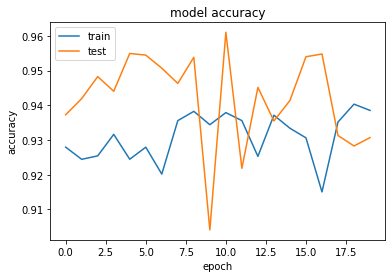

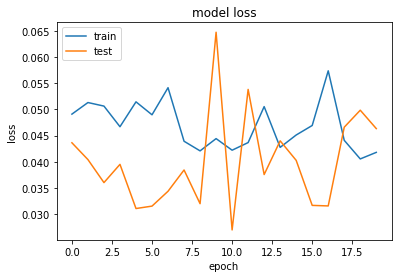

In [40]:
from matplotlib import pyplot as plt
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
s= model.predict(X_val)

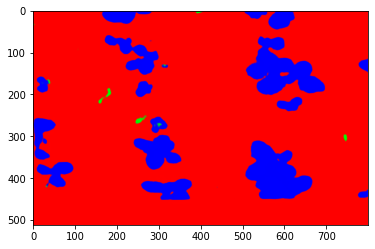

In [44]:
plt.imshow(s[1])

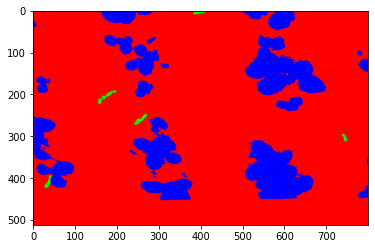

In [45]:
plt.imshow(Y_val[1])